In [19]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import mxnet as mx
from mxnet import nd, autograd, gluon

from sklearn import preprocessing
from sklearn.metrics import f1_score

### Load datasets:

In [20]:
file1 = 'realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv'
file2 = 'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv'

base_path = './data/'

train_df = pd.read_csv(base_path + file1)
validate_df = pd.read_csv(base_path + file2)
train_df.shape

(4032, 2)

### Add labels

In [21]:
labels_path = './data/combined_labels.json'

file = open(labels_path, 'r')
content = file.read()
labels = json.loads(content)
file.close()

train_df['anomaly_label'] = train_df['timestamp'].isin(
    labels[file1]).astype(int)

validate_df['anomaly_label'] = validate_df['timestamp'].isin(
    labels[file2]).astype(int)

train_df.head()

,timestamp,value,anomaly_label
0,2014-02-14 14:30:00,6.456,0
1,2014-02-14 14:35:00,5.816,0
2,2014-02-14 14:40:00,6.268,0
3,2014-02-14 14:45:00,5.816,0
4,2014-02-14 14:50:00,5.862,0


### Make timestamp conversions

In [22]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
validate_df['timestamp'] = pd.to_datetime(validate_df['timestamp'])

train_df['time_epoch'] = (train_df['timestamp'].astype(
    np.int64) / 100000000000).astype(np.int64)

validate_df['time_epoch'] = (validate_df['timestamp'].astype(
    np.int64) / 100000000000).astype(np.int64)

### Plot data with anomaly_labels

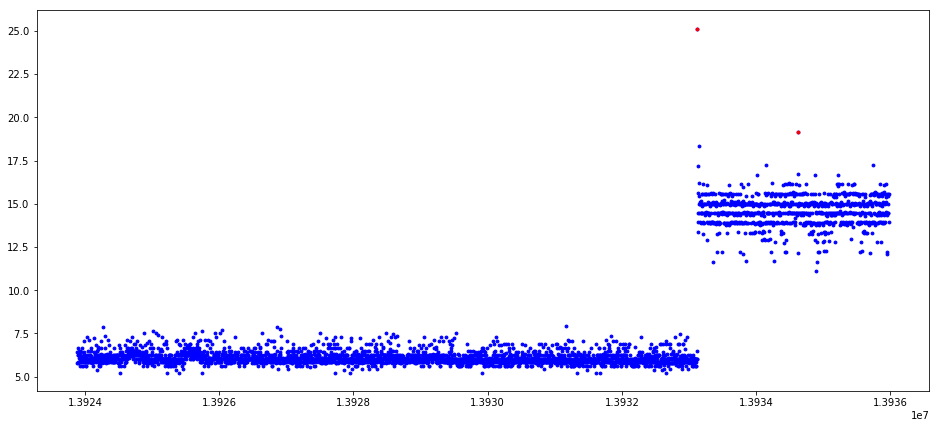

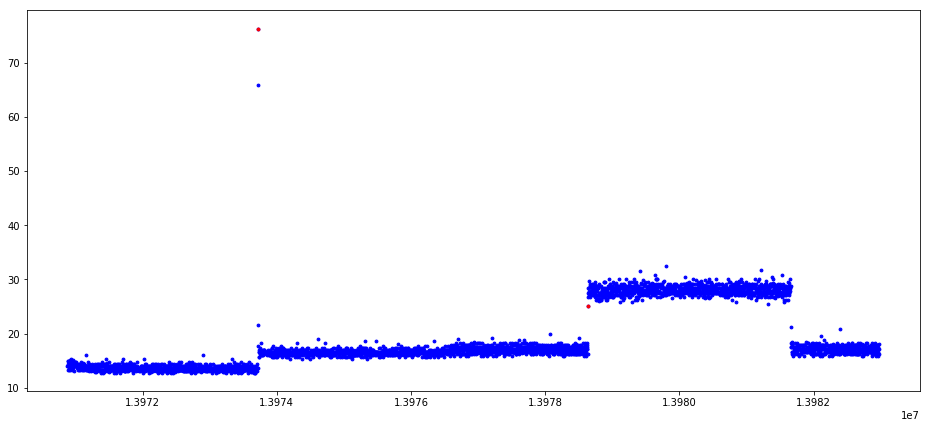

In [23]:
def plot(df):
    fig, ax = plt.subplots()

    a = df.loc[df['anomaly_label'] == 1, ['time_epoch', 'value']]

    ax.scatter(df['time_epoch'], df['value'], s=8, color='blue')
    ax.scatter(a['time_epoch'], a['value'], s=8, color='red')
    plt.show()


figsize(16, 7)

plot(train_df)
plot(validate_df)

### Scale the train data

In [24]:
feature_list = ['value']
features = len(feature_list)

min_max_scaler = preprocessing.StandardScaler()

train_data = min_max_scaler.fit_transform(
    train_df[feature_list].values.astype(np.float32))

### LSTM

In [25]:
batch_size = 24
rows = len(train_data)

split_factor = 0.8

train = train_data.astype(np.float32)[0:int(rows * split_factor)]
test = train_data.astype(np.float32)[int(rows * split_factor):]

train_data_batches = mx.gluon.data.DataLoader(train, batch_size, shuffle=False)
test_data_batches = mx.gluon.data.DataLoader(test, batch_size, shuffle=False)

In [26]:
ctx = mx.cpu()

In [27]:
model = mx.gluon.nn.Sequential()
with model.name_scope():
    model.add(mx.gluon.rnn.LSTM(features, dropout=0.2))
    model.add(mx.gluon.rnn.LSTM(features, dropout=0.2))

    model.add(mx.gluon.nn.Dense(features, activation='tanh'))

model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.01})

L = gluon.loss.L2Loss()

In [10]:
def evaluate_accuracy(data_iterator, model, L):
    loss_avg = 0.
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1, 1, features))
        label = data
        output = model(data)
        loss = L(output, label)
        loss_avg = loss_avg * i / (i + 1) + nd.mean(loss).asscalar() / (i + 1)
    return loss_avg

In [11]:
epochs = 40

all_train_mse = []
all_test_mse = []

for epoch in range(epochs):
    print('Epoch: ' + str(epoch))
    for i, data in enumerate(train_data_batches):
        data = data.as_in_context(ctx).reshape((-1, 1, features))
        label = data

        with autograd.record():
            output = model(data)
            loss = L(output, label)

        loss.backward()
        trainer.step(batch_size)

    train_mse = evaluate_accuracy(train_data_batches, model, L)
    test_mse = evaluate_accuracy(test_data_batches, model, L)
    all_train_mse.append(train_mse)
    all_test_mse.append(test_mse)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39


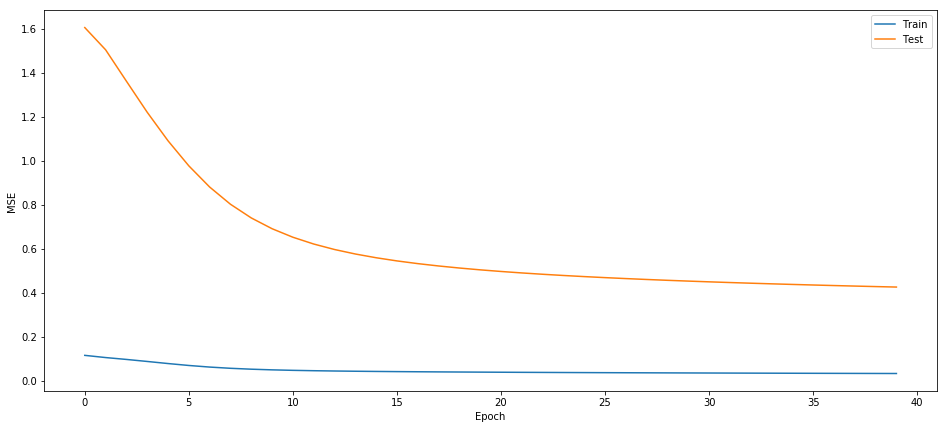

In [12]:
def plot_errors(train_mse, test_mse):
    epochs = range(len(train_mse))
    plt.plot(epochs, train_mse, label='Train')
    plt.plot(epochs, test_mse, label='Test')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


figsize(16, 7)

plot_errors(all_train_mse, all_test_mse)

In [13]:
def predict(to_predict, L):
    predictions = []
    for i, data in enumerate(to_predict):
        input = data.as_in_context(ctx).reshape((-1, features, 1))
        out = model(input)
        prediction = L(out, input).asnumpy().flatten()
        predictions = np.append(predictions, prediction)

    return predictions

In [14]:
train_data_all = mx.gluon.data.DataLoader(
    train_data.astype(np.float32), batch_size, shuffle=False)

train_predictions = predict(train_data_all, L)

threshold = np.mean(train_predictions) + 3 * np.std(train_predictions)

In [15]:
validate_data = min_max_scaler.fit_transform(
    validate_df[feature_list].values.astype(np.float32))

validate_data = mx.gluon.data.DataLoader(
    validate_data.astype(np.float32), batch_size, shuffle=False)

validation_predictions = predict(validate_data, L)

In [16]:
anomaly = list(map(lambda v: v > threshold, validation_predictions))

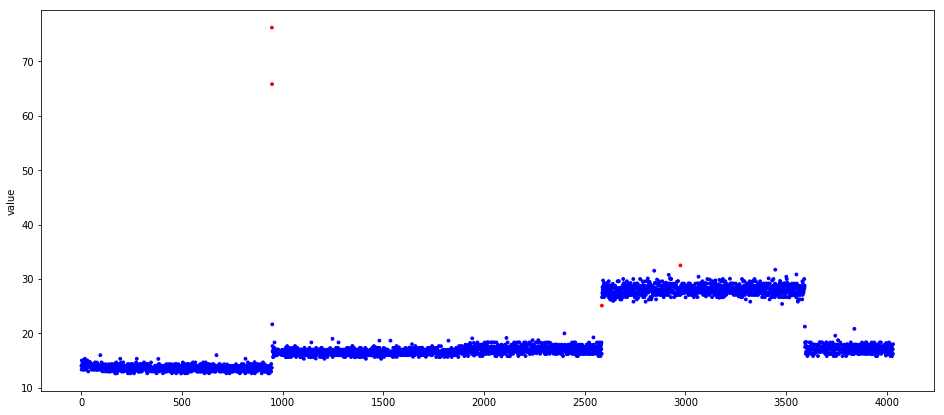

In [17]:
anomaly_dots = list(map(lambda v: "red" if v else "blue", anomaly))
plt.scatter(list(range(len(validate_df["value"]))),
            validate_df["value"], s=8, c=anomaly_dots)

plt.ylabel('value')

figsize(16, 7)

plt.show()

In [18]:
validate_labels = validate_df['anomaly_label'].astype(np.int64)
predicted_validate_anomalies = list(map(lambda v: 1 if v else 0, anomaly))

f_score = f1_score(validate_labels, predicted_validate_anomalies)
print('F1 score: ' + str(f_score))

F1 score: 0.6666666666666666
